# Dolly Sods Hydrology Analysis - Identifying Streams and Soil Moisture

In [1]:
# Imports
import arcpy, arcpy.sa, arcpy.conversion, arcpy.management, arcpy.analysis
import math
import matplotlib.pyplot as plt

# Define environment settings, check out Spatial Analyst extension
arcpy.env.workspace = r"C:\Users\tkerr1\Desktop\Grad_school\GEOG654\Final_project\Final_project_data\Final_project.gdb"
arcpy.env.overwriteOutput = True
arcpy.CheckOutExtension("Spatial")

'CheckedOut'

## Introduction
Dolly Sods Wilderness is a forest in West Virginia, and I go camping there pretty much every year. It is notably wet and boggy, especially in the northern area of the forest, yet it can be difficult to find streams from which to filter drinking water, especially since some that are marked on the map are only ephemeral (only contain water after rainfall) or seasonal (only contain water several months out of the year). I want to conduct a hydrology assessment using DEMs to better understand where I could get water (and avoid boggy ground) the next time I go camping.

There are various hydrological factors that can be derived from a DEM, however for the scope of this project I will stick to Topographic Wetness Index (TWI) and stream delineation. Stream delineation is a relatively straightforward process and TWI can be calculated using a rescaled flow accumulation raster (Chowdhury, 2023).

## Objectives
- Mask the DEM to our study area and reclassify it to 3m resolution
- Create stream networks for each threshold value
- Calculate TWI and reclassify it to fit 5 categories: very wet, wet, normal, dry, very dry
- Final outputs will be vector polyline datasets for each thresold value, and a TWI raster covering the study area

## Study Area
Dolly Sods Wilderness is located in eastern West Virginia, right next to Canaan Valley and Timberline Resort. It is roughly rectangular, with the northern portion being an alpine meadow ecosystem and the southern portion more of a temperate forest. The upper portion can get quite boggy in certain areas, the soil has poor drainage, while the southern area is bisected by Red Creek, a relatively fast flowing stream. The northern portion does not contain much fast-flowing water, meaning if you plan to camp there you need to pack in water. The southern portion has various tributaries of Red Creek running through it, and it is easy to find a campsite near water.

![Study Area](images/study_area.png)

## Methodology

#### Initial data prep: loading in primary data layers and fitting to our study area

In [ ]:
# Load in the Dolly Sods Wilderness boundary layer and the countywide DEM
dolly_sods_path = r"C:\Users\tkerr1\Desktop\Grad_school\GEOG654\Final_project\Final_project_data\Dolly_Sods_boundary\ForestWilderness.shp"
dem_path = r"C:\Users\tkerr1\Desktop\Grad_school\GEOG654\Final_project\Final_project_data\Dolly_Sods_DEM\DEM_Mosaic_FEMA_2018_Tucker_Randolph_WV_1m_UTM17.tif"
dem = arcpy.Raster(dem_path)

# Mask the countywide DEM to our study area
dem_masked = arcpy.sa.ExtractByMask(dem, dolly_sods_path)
dem_masked.save("dem_masked")
print("Masked DEM to AOI...")

Masked DEM to AOI...


### Background: setup for calculating Topographic Wetness Index

According to Riihimaki et al., the flow routing algorithm used in Flow Direction is very important to the final result. Arcpy offers 3 different algorithms: D8, Multiple Flow Direction (MFD), and D-Infinity (Dinf). Riihimaki et al. state that D8 is the most simplistic flow routing algorithm; while they tested more algorithms in addition to these three, their findings suggest that from these three, Dinf will perform the best.

DEM resolution is another factor that influences the TWI result. Interestingly, Riihimaki et al. found that the highest DEM resolution they tested (1m, which happens to be our DEM resolution) did not perform the best. They attributed this to lidar errors, because the point spacing was roughly equivalent to cell size. They found that Dinf reached its maximal explanatory power at 3m resolution. As a result, resampling the DEM to 3m is included in this TWI workflow, as well as the Dinf algorithm

#### Part 1: locate streams according to various thresholds
The basic workflow will be:
- Resample the DEM to 3m
- Fill sinks
- Determine flow direction
- Determine flow accumulation using Dinf algorithm
- Threshold the flow accumulation result and save each iteration

In [ ]:
# Resample the DEM to 3m resolution (use the bilinear method since it best suits our continuous data)
arcpy.management.Resample("dem_masked", "dem_3m", 3, "BILINEAR")
print("DEM resampled to 3m resolution...")

# Fill the DEM to remove sinks
dem_3m = arcpy.Raster("dem_3m")
fill = arcpy.sa.Fill(dem_3m)
print("Filled sinks...")

# Determine flow direction using Dinf algorithm
flow_dir = arcpy.sa.FlowDirection(fill, flow_direction_type="DINF")
print("Flow Direction calculated using Dinf algorithm...")

# Determine flow accumulation
flow_acc = arcpy.sa.FlowAccumulation(flow_dir, flow_direction_type="DINF")
print("Flow Accumulation calculated...")

DEM resampled to 3m resolution...
Filled sinks...
Flow Direction calculated using Dinf algorithm...
Flow Accumulation calculated...


##### Determining a threshold value for stream definition
On page 73 of the book Arc Hydro: GIS for Water Resources by David Maidment, he specifies a value of 5,000 be used with a cell size of 30m; this means it takes a drainage area of 4.5km $^2$ to generate a stream (5,000 x 30 x 30 = 4,500,000m $^2$). He also notes that below 1,000, defining catchement area becomes questionable, especially in regions of flat terrain.

In our case we are using a 3m DEM, so in order to generate a drainage area of 4.5km $^2$ we would use a threshold value of 500,000. We will test values ranging from 5,000 to 500,000 with a step of 50,000. While this minimum threshold and step values are arbitrary, I believe they cover both uncertain and certain stream outputs, while keeping number of output datasets low.

In [ ]:
# Threshold the flow accumulation result with values between 50,000 and 500,000, save the output as a vector
for i in range(5000, 550000, 50000):
    where = f"VALUE > {i}"

    # Threshold to given value
    streams = arcpy.sa.Con(flow_acc, 1, 0, where)
    streams.save(f"streams_{i}")

    # Convert to a polyline (for maps later)
    arcpy.conversion.RasterToPolyline(streams, f"streams_poly_{i}", simplify="SIMPLIFY")
    print(f"Saved streams_{i}...")

Saved streams_5000...
Saved streams_55000...
Saved streams_105000...
Saved streams_155000...
Saved streams_205000...
Saved streams_255000...
Saved streams_305000...
Saved streams_355000...
Saved streams_405000...
Saved streams_455000...
Saved streams_505000...


#### Part 2: creating a TWI raster
TWI is a proxy for soil moisture according to Riihimaki et al. They and some others (Chowdhury et al., Kopecky et al.) interpret similar neighboring TWI values to indicate tendency for those areas to store water in favorable conditions, and higher values indicate cells more likely to become saturated. They also agree on a common equation for calculating TWI (assuming slope is in radians):<br><br> $TWI=ln(\frac{flow acc}{\tan slope})$

Basic workflow based on Chowdhury et al.:
- Create a slope raster from our 3m filled DEM
- Convert the slope from degrees to radians
- Calculate Tan of slope, using a constant of 0.001 to rule out radian slopes > 0
- Rescale flow accumulation by adding 1, to remove any 0 values and multiply by pixel size to calculate flow path
- Calculate TWI using the equation

In [ ]:
# Calculate slope
slope = arcpy.sa.Slope(fill)
print("Calculated slope...")

# Convert to radians: pi radians / 180 degrees
slope_radians = slope * math.pi / 180.0
print("Converted slope from degrees to radians...")

# Calculate tan of slope
tan_slope = arcpy.sa.Con(slope_radians > 0, arcpy.sa.Tan(slope_radians), 0.001)

# Rescale flow accumulation
rescale_flow_acc = (flow_acc + 1) * 3

# Calculate TWI
twi = arcpy.sa.Ln(rescale_flow_acc / tan_slope)
twi.save("TWI_raster")
print("Calculated TWI...")

Calculated slope...
Converted slope from degrees to radians...
Calculated TWI...


##### Reclassifying the TWI raster based on percentile rank for better interpretation
Meles et al. propose to reclassify the TWI raster according to percentiles for better interpretation. The cutoffs they use are <10th, 10th-25th, 25th-75th, 75th-90th, and >90th to describe very dry, dry, normal, wet, and very wet conditions, respectively.<br><br>
Basic workflow will be:
- Use Zonal Statistics as Table to determine percentile breaks
- Use a Search Cursor to locate these and assign them to a RemapRange
- Reclassify the raster accordingly

In [ ]:
# Calculate Zonal Statistics
arcpy.sa.ZonalStatisticsAsTable(dolly_sods_path, "FID", twi, "TWI_percentiles", statistics_type="PERCENTILE", percentile_values=[10, 25, 75, 90])
print("Calculated percentages...")

# Extract percentiles from the table
with arcpy.da.SearchCursor("TWI_percentiles", ['PCT10', 'PCT25', 'PCT75', 'PCT90']) as sc:
    for row in sc:
        pct_10 = row[0]
        pct_25 = row[1]
        pct_75 = row[2]
        pct_90 = row[3]

# Define a RemapRange for the percentiles
remap_range = arcpy.sa.RemapRange([[twi.minimum, pct_10, 1], [pct_10, pct_25, 2], [pct_25, pct_75, 3], [pct_75, pct_90, 4], [pct_90, twi.maximum, 5]])

# Reclassify the TWI raster
twi_reclass = arcpy.sa.Reclassify(twi, "VALUE", remap_range)
twi_reclass.save("TWI_reclass")
print("TWI reclassified and saved...")

Calculated percentages...
TWI reclassified and saved...


## Results

##### Stream networks at different threshold levels

| | | |
|:-------------------------:|:-------------------------:|:-------------------------:|
|![streams 5000](images/streams_5000.png) Streams 5,000 |![streams 55000](images/streams_55000.png) Streams 55,000|![streams 105000](images/streams_105000.png) Streams 105,000|
|![streams 155000](images/streams_155000.png) Streams 155,000|![streams 205000](images/streams_205000.png) Streams 205,000|![streams 255000](images/streams_255000.png) Streams 255,000|
|![streams 305000](images/streams_305000.png) Streams 305,000|![streams 355000](images/streams_355000.png) Streams 355,000|![streams 405000](images/streams_405000.png) Streams 405,000|
|![streams 455000](images/streams_455000.png) Streams 455,000|![streams 505000](images/streams_505000.png) Streams 505,000|![TWI raster](images/TWI_raster.png) TWI raster|

## Model Evaluation
Finding observed data on streams and soil moisture is difficult, but fortunately the National Map had hydrography data for the eastern region of West Virginia. We will use these streams as our observed data (after preprocessing them and converting to a raster), and the raster stream networks for each threshold as our predicted data. Before calculating accuracy metrics, we will also buffer the streams to 6 meters. This will account for some stream network pixels being in the correct stream channel, but being separated from the observed streams by only a pixel or two. Our measure of model accuracy will be the percentage of accurate pixels, or total number of overlapping pixels divided by total pixels in the stream network. Additionally, since we have 11 different stream networks, we will compare the total overlap for each of the predicted stream networks; the network with the highest overlap will be the highest performing. <br><br>

Basic workflow:
- Preprocess the hydrography dataset (reproject, clip to study area, buffer to 3m, and convert to raster with 3m cell size)
- Reclassify the hydrography raster to binary
- Use map algebra to calculate how many pixels overlap between observed and predicted
- Compare percent accuracy for each predicted stream network

##### Preprocessing

In [ ]:
# Load in the observed streams
dolly_sods_hydrography = r"C:\Users\tkerr1\Desktop\Grad_school\GEOG654\Final_project\Final_project_data\Dolly_Sods_hydrography\Dolly_Sods_hydrography.shp"

# Reproject streams to project CRS
project_crs = arcpy.Describe("streams_5000").spatialReference
arcpy.management.Project(dolly_sods_hydrography, "wv_e_hydrography", project_crs)

# Clip to study area
arcpy.analysis.Clip("wv_e_hydrography", dolly_sods_path, "dolly_sods_hydrography")

# Buffer to 3m
arcpy.analysis.Buffer("dolly_sods_hydrography", "ds_buffer", 6, dissolve_option="ALL")

# Convert to raster
arcpy.conversion.PolygonToRaster("ds_buffer", "OBJECTID", "dolly_sods_hydrography_raster", cellsize=3)

# Create observed stream mask
obs_streams = arcpy.Raster("dolly_sods_hydrography_raster")
obs_stream_mask = arcpy.sa.Con(obs_streams > 0, 1, 0)
obs_stream_mask.save("obs_streams_mask")
print("Observed streams raster created...")

Observed streams raster created...


| | |
|:-------------------------:|:-------------------------:|
|![Observed streams](images/observed_streams.png) Observed streams|![Observed streams w buffer](images/observed_streams_w_buffer.png) Observed streams with a 6m buffer|

##### Visualizing the results

In [ ]:
# Initialize a dictionary to store accuracy pixels, and use raster algebra on each of the predicted streams to calculate overlap
overlap_pixels = {}

for i in range(5000, 550000, 50000):
    # Load in predicted stream network
    pred = arcpy.Raster(f"streams_{i}")

    # Multiply with observed stream network
    overlap = obs_stream_mask * pred

    # Save the result
    overlap.save(f"overlap_{i}")
    print(f"Saved overlap_{i}...")

    # Add percent accuracy to dictionary
    accuracy_pct = (overlap.sum / obs_stream_mask.sum) * 100
    overlap_pixels.update({f"overlap_{i}": accuracy_pct})

Saved overlap_5000...
Saved overlap_55000...
Saved overlap_105000...
Saved overlap_155000...
Saved overlap_205000...
Saved overlap_255000...
Saved overlap_305000...
Saved overlap_355000...
Saved overlap_405000...
Saved overlap_455000...
Saved overlap_505000...


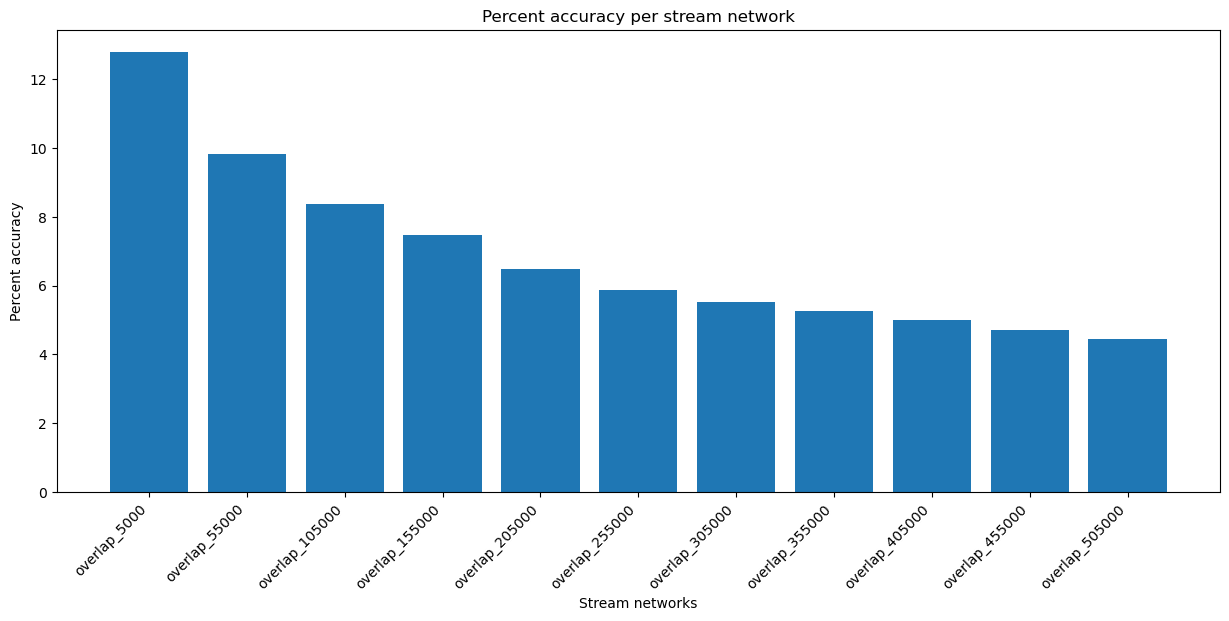

In [ ]:
# Plot the accuracy percentage for each predicted stream network
plt.figure(figsize=(15,6))
plt.bar(overlap_pixels.keys(), overlap_pixels.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Stream networks")
plt.ylabel("Percent accuracy")
plt.title("Percent accuracy per stream network")
plt.show()

## Discussion
According to the above graph, the prediction accuracy is highest for a threshold of 5,000, and decreases as the threshold gets larger. This is interesting, as the literature suggests otherwise. As previously discussed, Maidment states that a higher threshold means there are more upstream cells contributing flow into that cell. This should make it more likely that the cell is a part of an established water channel, and therefore more likely to show up on a map or in this case, a national hydrography dataset.
<br><br>
Instead, 5,000, the lowest threshold (with less upstream contributing cells), has the highest accuracy at approximately 12%. The lowest was 505,000 at approximately 4%. There seems to be more going on behind the scenes here.
<br><br>
One possible factor influencing these results is in the accuracy metric itself: it is a binary presence/absence measure, which fails to account for the numerous false positives and negatives that are seen at lower threshold levels. See below, where we compare Observed streams with Predicted at the highest (505,000) and lowest (5,000) thresholds. While the 5,000 threshold has the highest accuracy, we can see it also has many more false positive pixels than the 505,000 threshold.
<br><br>
Further accuracy assessment would give deeper insight here. For example, instead of using a binary mask for the observed streams, reclassifying it to values of 3 and 5 for absence and presence, respectively, and then reclassifying the predicted stream networks to values of 2 and 4 for absence and presence, respectively would allow for a simple map algebra multiplication; this would yield a confusion matrix of the total true positive and negatives, and false positives and negatives. Each threshold could then be scored according to this more in-depth metric.

| | |
|:-------------------------:|:-------------------------:|
|![Obs pred streams 5000](images/obs_pred_streams_5000.png) Observed and predicted streams at 5,000|![Obs pred streams 505000](images/obs_pred_streams_505000.png) Observed and predicted streams at 505,000|

## Conclusion
Hydrology analysis not a straightforward process and depends on many assumptions about your study area. It is often a best-case scenario, and the results are suggestions more than they are fact. This particular analysis would have been greatly helped by some field data. Many of the articles cited here relied on plots measuring soil moisture or stream width, and used these in evaluating their model. Without this data, our findings are limited. Another limiting factor is the choice of flow routing algorithm. The main journal article discusses (Riihimaki et al.) evaluates 11 different flow routing algorithms in their analysis. ArcGIS only offers 3, and truly supports only the D8 (as many algorithms using flow direction as an input require it to be of integer data type, which the other two algorithms do not use). Building out a more sophisticated workflow in another GIS (e.g. SAGA GIS, the software used by Riihimaki et al.) should definitely be considered for a future analysis.
<br><br>
I do feel I can go back to Dolly Sods as a more informed camper though. Calculating TWI showed me which areas are most likely to be marshy, which were mainly in the north of the forest, with an area in the southwest also looking pretty wet. The stream networks we calculated also showed tributaries that are not marked on the hydrography dataset we used as our observed data, so it will be interesting to ground truth these the next time I go. I suppose I will find out whether they are ephemeral streams, or perhaps just small depressions that are a little more likely to contain water than the surrounding area.
<br><br>
It would be interesting to revisit this analysis with an updated flow routing workflow, field data and an updated model evaluation method.

### References
<p style="text-indent: -0.5in; margin-left: 0.5in;">
Beven, K., & Kirkby, M. J. (1979). A physically based, variable contributing area model of basin hydrology. <i>Hydrological Sciences Journal, 24</i>(1), 43–69. https://doi.org/10.1080/02626667909491834
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
Chowdhury, S. (2023). Modelling hydrological factors from DEM using GIS. <i>MethodsX, 10</i>, 102062. https://doi.org/10.1016/j.mex.2023.102062
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
Esri. (n.d.). Identifying stream networks. <i>ArcGIS Pro</i>. Retrieved 10/28/2024, from https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/identifying-stream-networks.htm
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
Riihimäki, H., Kemppinen, J., Kopecký, M., & Luoto, M. (2021). Topographic Wetness Index as a proxy for soil moisture: The importance of flow-routing algorithm and grid resolution. <i>Water Resources Research, 57</i>(10). https://doi.org/10.1029/2021WR029871
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
Kopecký, M., Macek, M., & Wild, J. (2020). Topographic Wetness Index calculation guidelines based on measured soil moisture and plant species composition. <i>Science of the Total Environment, 757</i>, 143785. https://doi.org/10.1016/j.scitotenv.2020.143785
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
Maidment, D. R. (Ed.). (2002). <i>Arc Hydro: GIS for Water Resources</i> (p. 73). ESRI Press.
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
Meles, M. B., Younger, S. E., Jackson, C. R., Du, E., & Drover, D. (2020). Wetness index based on landscape position and topography (WILT): Modifying TWI to reflect landscape position. <i>Journal of Environmental Management, 255</i>, 109863. https://doi.org/10.1016/j.jenvman.2019.109863
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
U.S. Forest Service. (n.d.). Monongahela National Forest - GIS Data and Map Products. United States Department of Agriculture. Retrieved 11/13/2024 from https://www.fs.usda.gov/detail/mnf/landmanagement/gis/?cid=stelprdb5108081
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
U.S. Geological Survey. (n.d.). The National Map downloader. U.S. Department of the Interior. Retrieved 11/13/2024, from https://apps.nationalmap.gov/downloader/
</p>

<p style="text-indent: -0.5in; margin-left: 0.5in;">
West Virginia GIS Technical Center. (n.d.). FEMA 2018-19 Tucker-Randolph WV 1m UTM17 DEM Project Mosaic. West Virginia University. Retrieved October 28, 2024, from https://data.wvgis.wvu.edu/pub/Clearinghouse/Elevation/QL2Lidar/1_LiDAR_QL2_projects_and_metadata/FEMA_2018-19_Tucker-Randolph_WV_1m_UTM17/DEM/ProjectMosaic/
</p>
